Importing Libraries

In [ ]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import os
from gymnasium import spaces
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor   import Monitor
from stable_baselines3 import DQN, PPO, A2C
import pygame
import sys

Crop Irrigation Environment

In [9]:
class CropIrrigationOptimization(gym.Env):
    def __init__(self):
        super().__init__()
        self.days = 120
        self.depth = 0.5
        self.max_moist = 0.35
        self.min_moist = 0.10
        self.max_water = 10.0
        self.steps = 11
        high = np.array([1.0, 20.0, 1.2, 6.0, 1.0, 1.0, self.max_water], dtype=np.float32)
        low = np.array([0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.action_space = spaces.Discrete(self.steps)
        self.day = 0
        self.moisture = 0.0
        self.gdd = 0.0
        self.last_water = 0.0
        self.streak = 0
        self.got_bonus = False

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.day = 0
        self.moisture = self.np_random.uniform(self.min_moist, self.max_moist)
        self.gdd = 0.0
        self.last_water = 0.0
        self.streak = 0
        self.got_bonus = False
        return self._obs(), {}

    def step(self, action):
        water = (action / (self.steps - 1)) * self.max_water
        rain, temp, sun = self._weather(self.day)
        et0 = self._et0(temp, sun)
        kc = self._kc()
        ks = self._ks()
        et_use = et0 * kc * ks
        change = (rain + water - et_use) / (self.depth * 1000.0)
        self.moisture = np.clip(self.moisture + change, self.min_moist, self.max_moist)
        self.gdd += max(0.0, temp - 10.0)
        self.last_water = water
        self.day += 1
        reward = self._reward(water)
        if temp > 35:
            reward -= (temp - 35) * 0.1
        elif temp < 5:
            reward -= (5 - temp) * 0.1
        vpd = sun / (temp + 273.15)
        if vpd > 0.02:
            reward -= (vpd - 0.02) * 2.0
        norm_moist = (self.moisture - self.min_moist) / (self.max_moist - self.min_moist)
        if norm_moist > 0.9:
            reward -= (norm_moist - 0.9)
        if 0.6 <= norm_moist <= 0.9:
            self.streak += 1
        else:
            self.streak = 0
        done = self.day >= self.days
        if done and not self.got_bonus and self.streak >= 80:
            reward += 25.0
            self.got_bonus = True
        return self._obs(), reward, done, False, {}

    def _obs(self):
        norm_moist = (self.moisture - self.min_moist) / (self.max_moist - self.min_moist)
        rain, temp, sun = self._weather(self.day)
        et0 = self._et0(temp, sun)
        kc = self._kc()
        lai = self._lai(kc)
        gdd_norm = min(self.gdd / (15.0 * self.days), 1.0)
        day_norm = self.day / self.days
        return np.clip(np.array([norm_moist, et0, kc, lai, gdd_norm, day_norm, self.last_water], dtype=np.float32), self.observation_space.low, self.observation_space.high)

    def _weather(self, day):
        d = day % 365
        avg_temp = 15 + 10 * np.sin(2*np.pi*(d-90)/365)
        temp = avg_temp + self.np_random.normal(0, 3)
        avg_sun = 20 + 10 * np.sin(2*np.pi*(d-90)/365)
        sun = max(0, avg_sun + self.np_random.normal(0, 5))
        rain = 0.0
        if self.np_random.random() < 0.15:
            rain = self.np_random.gamma(2.0, 3.0)
        return max(0, rain), temp, sun

    def _et0(self, temp, sun):
        return max(0.0, 0.0023 * sun * (temp + 17.8) * np.sqrt(max(0, temp)))

    def _kc(self):
        x = self.gdd / (8.0 * self.days)
        val = 0.2 + 1.0 / (1.0 + np.exp(-10 * (x - 0.5)))
        return np.clip(val, self.observation_space.low[2], self.observation_space.high[2])

    def _ks(self):
        norm_moist = (self.moisture - self.min_moist) / (self.max_moist - self.min_moist)
        return float(np.clip(norm_moist / 0.5, 0.0, 1.0))

    def _lai(self, kc):
        low_kc, high_kc = self.observation_space.low[2], self.observation_space.high[2]
        low_lai, high_lai = self.observation_space.low[3], self.observation_space.high[3]
        if high_kc > low_kc:
            return low_lai + (high_lai - low_lai) * (kc - low_kc) / (high_kc - low_kc)
        return low_lai

    def _reward(self, water):
        norm_moist = (self.moisture - self.min_moist) / (self.max_moist - self.min_moist)
        if norm_moist < 0.6:
            moist_score = norm_moist / 0.6
        elif norm_moist > 0.9:
            moist_score = (1.0 - norm_moist) / 0.1
        else:
            moist_score = 1.0
        growth_score = self._ks() * 0.5
        water_cost = - (water / self.max_water) * 0.5
        stress_penalty = -1.0 if self.moisture <= self.min_moist else 0.0
        return moist_score + growth_score + water_cost + stress_penalty

PyGame Render Environment

In [ ]:
class IrrigationRenderer:
    def __init__(self, environment: CropIrrigationOptimization, crop_image_paths=None):
        self.environment = environment
        self.crop_image_paths = crop_image_paths or {}
        self.initialized = False
        self.crop_images = {}
        self.width, self.height = 480, 600
        self.color_white = (255, 255, 255)
        self.color_black = (0, 0, 0)
        self.color_blue = (100, 149, 237)
        self.color_yellow = (255, 255, 0)
        self.color_red = (255, 0, 0)
        self.color_grey = (128, 128, 128)
        self.crop_image_area = pygame.Rect(10, 50, 230, 300)
        self.moisture_bar = pygame.Rect(260, 50, 50, 200)
        self.info_panel = pygame.Rect(260, 270, 210, 320)
        self.total_days_per_phase = [0, 0, 0]
        self.optimal_days_per_phase = [0, 0, 0]
        self.previous_phase = -1

    def _initialize_pygame(self):
        pygame.init()
        self.display = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()
        self.font_small = pygame.font.SysFont(None, 24)
        self.font_large = pygame.font.SysFont(None, 36)
        for stage, path in self.crop_image_paths.items():
            try:
                image = pygame.image.load(path)
                self.crop_images[stage] = image.convert_alpha()
            except Exception:
                self.crop_images[stage] = None
        self.initialized = True

    def render(self, mode='human'):
        if not self.initialized:
            self._initialize_pygame()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                sys.exit()
        phase_duration = self.environment.days // 3
        current_phase  = min(self.environment.day // phase_duration, 2)
        if current_phase != self.previous_phase:
            self.total_days_per_phase   = [0,0,0]
            self.optimal_days_per_phase = [0,0,0]
            self.previous_phase = current_phase
        theta_range       = self.environment.max_moist - self.environment.min_moist
        normalized_moist  = (self.environment.moisture - self.environment.min_moist) / theta_range
        self.total_days_per_phase[current_phase] += 1
        if 0.6 <= normalized_moist <= 0.9:
            self.optimal_days_per_phase[current_phase] += 1
        optimal_ratio = self.optimal_days_per_phase[current_phase] \
                      / self.total_days_per_phase[current_phase]
        if optimal_ratio < 0.30:
            growth_stage = 'stressed'
        else:
            growth_stage = ['seedling','vegetative','mature'][current_phase]
        crop_image = self.crop_images.get(growth_stage)
        self.display.fill(self.color_white)
        header = self.font_large.render(f"Day {self.environment.day}/{self.environment.days}", True, self.color_black)
        self.display.blit(header, (self.width//2 - header.get_width()//2, 10))
        if crop_image:
            w,h = crop_image.get_size()
            tw, th = self.crop_image_area.size
            aspect = w/h
            if w/h > tw/th:
                sw, sh = tw, int(tw/aspect)
            else:
                sh, sw = th, int(th*aspect)
            scaled = pygame.transform.smoothscale(crop_image, (sw, sh))
            rect   = scaled.get_rect(center=self.crop_image_area.center)
            self.display.blit(scaled, rect)
        else:
            no_img = self.font_small.render("No Crop Img", True, self.color_red)
            self.display.blit(no_img, self.crop_image_area.center)
        pygame.draw.rect(self.display, self.color_grey, self.moisture_bar)
        fill_h = int(normalized_moist * self.moisture_bar.height)
        mo_rect = pygame.Rect(self.moisture_bar.x, self.moisture_bar.y + self.moisture_bar.height - fill_h, self.moisture_bar.width, fill_h)
        pygame.draw.rect(self.display, self.color_blue, mo_rect)
        pygame.draw.line(self.display, self.color_red, (self.moisture_bar.x-5, self.moisture_bar.bottom), (self.moisture_bar.right+5, self.moisture_bar.bottom), 2)
        pygame.draw.line(self.display, self.color_yellow, (self.moisture_bar.x-5, self.moisture_bar.y), (self.moisture_bar.right+5, self.moisture_bar.y), 2)
        y = self.info_panel.y + 5
        metrics = [f"Irrigation: {self.environment.last_water:.1f} mm", f"Soil Moisture (θ): {self.environment.moisture:.2f}", f"Cumulative GDD:   {self.environment.gdd:.1f}", f"Optimal % (Phase {current_phase}): {optimal_ratio*100:.0f}%"]
        for line in metrics:
            surf = self.font_small.render(line, True, self.color_black)
            self.display.blit(surf, (self.info_panel.x+5, y))
            y += 25
        pygame.display.flip()
        if mode == 'human':
            self.clock.tick(30)  
        elif mode == 'rgb_array':
            frame = pygame.surfarray.array3d(self.display)
            return np.transpose(frame, (1,0,2)).astype(np.uint8)

    def close(self):
        if self.initialized:
            pygame.quit()

Self Implemented DQN

In [4]:
#Simple DQN Neural Network
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)

#Agent using DQN
class DQNAgent:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.98
        self.learning_rate = 0.002
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(input_size, output_size).to(self.device)
        self.target_net = DQN(input_size, output_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.update_target_net()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.output_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return int(torch.argmax(q_values))

    def train_step(self, batch_size):
        if len(self.memory) < batch_size:
            return
        samples = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in samples:
            state = torch.FloatTensor(state).to(self.device)
            next_state = torch.FloatTensor(next_state).to(self.device)
            q_values = self.policy_net(state)
            target_values = q_values.clone()
            if done:
                target_values[action] = reward
            else:
                next_q = self.target_net(next_state)
                target_values[action] = reward + self.gamma * torch.max(next_q).item()
            loss = F.mse_loss(q_values[action], target_values[action])
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

#Training the Agent
def train_agent(env, agent, total_episodes=1000, batch_size=32, model_path="dqn_model.pth"):
    episode_rewards = []
    epsilons = []
    for episode in range(1, total_episodes + 1):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        done = False
        episode_reward = 0.0
        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            done = terminated or truncated
            agent.store_experience(state, action, reward, next_state, done)
            agent.train_step(batch_size)
            state = next_state
            episode_reward += reward
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        episode_rewards.append(episode_reward)
        epsilons.append(agent.epsilon)
        if episode % 10 == 0:
            agent.update_target_net()
        if episode % 100 == 0:
            print(f"Episode {episode} - Reward: {episode_reward:.2f} - Epsilon: {agent.epsilon:.3f}")
    torch.save(agent.policy_net.state_dict(), model_path)
    return episode_rewards, epsilons

#Evaluating the Trained Agent
def test_agent(env, agent, test_episodes=10):
    agent.policy_net.eval()
    scores = []
    for _ in range(test_episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        done = False
        total_score = 0.0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
            with torch.no_grad():
                q_values = agent.policy_net(state_tensor)
            action = int(torch.argmax(q_values))
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = np.array(next_state, dtype=np.float32)
            done = terminated or truncated
            total_score += reward
        scores.append(total_score)
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"Test results - Avg: {mean_score:.2f} ± {std_score:.2f}")
    return scores

#Plotting results
def show_training_stats(rewards, epsilons):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.subplot(1, 2, 2)
    plt.plot(epsilons)
    plt.title("Epsilon over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.tight_layout()
    plt.show()

Episode 100 - Reward: 70.78 - Epsilon: 0.133
Episode 200 - Reward: 141.90 - Epsilon: 0.018
Episode 300 - Reward: 110.94 - Epsilon: 0.002
Episode 400 - Reward: 159.51 - Epsilon: 0.001
Episode 500 - Reward: 147.78 - Epsilon: 0.001
Episode 600 - Reward: 143.77 - Epsilon: 0.001
Episode 700 - Reward: 126.35 - Epsilon: 0.001
Episode 800 - Reward: 185.55 - Epsilon: 0.001
Episode 900 - Reward: 128.34 - Epsilon: 0.001
Episode 1000 - Reward: 146.58 - Epsilon: 0.001


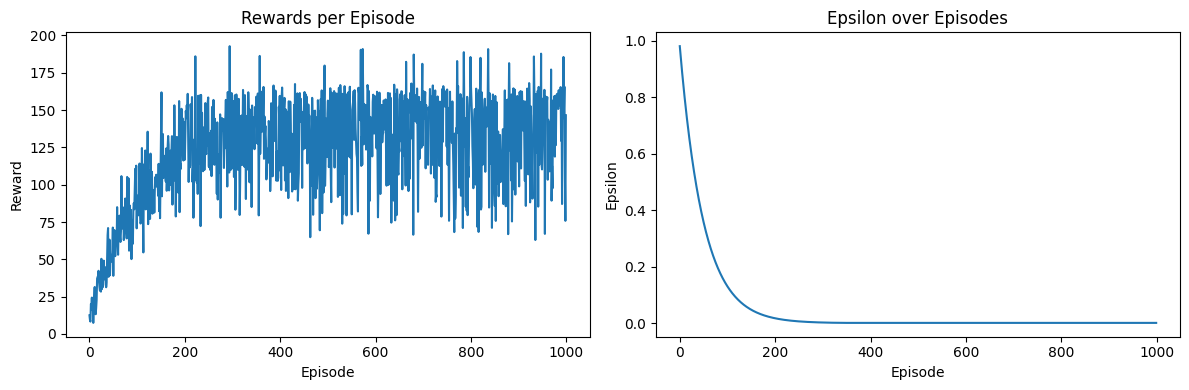

Test results - Avg: 124.31 ± 26.48


In [6]:
if __name__ == "__main__":
    env = CropIrrigationOptimization()

    #Creating agent
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    agent = DQNAgent(input_size, output_size)
    
    #Training agent
    all_rewards, all_epsilons = train_agent(env, agent, total_episodes=1000, batch_size=64, model_path="dqn_self_1000.pth")
    show_training_stats(all_rewards, all_epsilons)
    agent.policy_net.load_state_dict(torch.load("dqn_self_1000.pth"))
    test_agent(env, agent, test_episodes=10)

Test results - Avg: 122.94 ± 24.09
Test rewards: [74.62158005501152, 139.7118588367787, 110.43973488500266, 157.31325807579404, 152.97027014376874, 119.0922928526948, 95.54135646562978, 135.49657906879497, 118.70656993385599, 125.51984472980747]


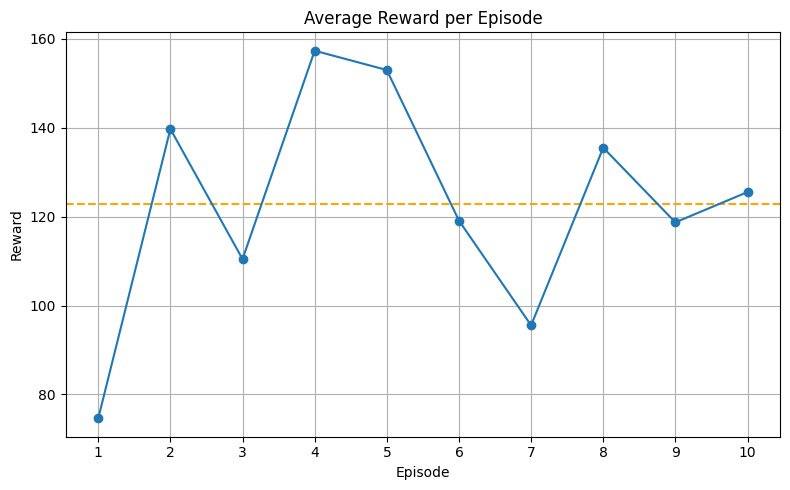

In [7]:
#Loading trained model
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = DQNAgent(input_size, output_size)
agent.policy_net.load_state_dict(torch.load("dqn_self_1000.pth"))
num_tests = 10
test_rewards = test_agent(env, agent, test_episodes=num_tests)

#Calculating average
avg = sum(test_rewards) / num_tests
print(f"Test rewards: {test_rewards}")

#Plotting results
plt.figure(figsize=(8, 5))
plt.axhline(avg, color='orange', linestyle='--')
plt.plot(range(1, num_tests + 1), test_rewards, marker='o')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average Reward per Episode")
plt.xticks(range(1, num_tests + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
if __name__ == "__main__":
    environment = CropIrrigationOptimization()

    agent = DQNAgent(environment.observation_space.shape[0],environment.action_space.n)
    agent.policy_net.load_state_dict(torch.load("dqn_self_1000.pth", map_location=agent.device))
    agent.policy_net.eval()
    crop_images = {'seedling': 'seedling.png', 'vegetative': 'vegetative.png', 'mature': 'mature.png', 'stressed': 'stressed.png'}
    visualizer = IrrigationRenderer(environment, crop_image_paths=crop_images)
    observation, _ = environment.reset()
    observation = np.array(observation, dtype=np.float32)
    episode_done = False
    cumulative_reward = 0.0
    
    while not episode_done:
        with torch.no_grad():
            q_values = agent.policy_net(torch.FloatTensor(observation).to(agent.device).unsqueeze(0))
        selected_action = int(q_values.argmax().item())
        next_observation, reward, terminated, truncated, _ = environment.step(selected_action)
        observation = np.array(next_observation, dtype=np.float32)
        cumulative_reward += reward
        episode_done = terminated or truncated
        visualizer.render(mode=None)
        pygame.time.delay(100)
    print(f"Episode completed. Total reward: {cumulative_reward:.2f}")
    visualizer.close()
    environment.close()

Episode completed. Total reward: 155.59


Self Implemented A2C

In [12]:
#Actor-Critic Model
class ActorCriticModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.hidden_layer = nn.Linear(state_dim, 128)
        self.policy_layer = nn.Linear(128, action_dim)
        self.value_layer = nn.Linear(128, 1)

    def forward(self, state):
        x = F.relu(self.hidden_layer(state))
        action_probs = F.softmax(self.policy_layer(x), dim=-1)
        state_value = self.value_layer(x)
        return action_probs, state_value.squeeze(-1)

#computed discount rates
def compute_discounted_returns(rewards, gamma=0.99):
    discounted_returns = []
    total_return = 0.0
    for reward in reversed(rewards):
        total_return = reward + gamma * total_return
        discounted_returns.insert(0, total_return)
    return torch.tensor(discounted_returns, dtype=torch.float32)

#Training loop for Actor-Critic on SyntheticIrrigationEnv
def train_actor_critic(environment: gym.Env,model: ActorCriticModel,optimizer: optim.Optimizer,num_episodes: int = 1000,gamma: float = 0.99,):
    episode_rewards = []
    for episode in range(1, num_episodes + 1):
        state, _ = environment.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        rewards = []
        log_probabilities = []
        state_values = []
        total_episode_reward = 0.0

        #Generating episode
        while not done:
            action_probs, state_value = model(state.unsqueeze(0))
            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample().item()
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated
            log_probabilities.append(action_distribution.log_prob(torch.tensor(action)))
            state_values.append(state_value.squeeze(0))
            rewards.append(reward)
            total_episode_reward += reward
            state = torch.tensor(next_state, dtype=torch.float32)

        #Computing returns and advantages
        returns = compute_discounted_returns(rewards, gamma)
        state_values_tensor = torch.stack(state_values)
        log_probabilities_tensor = torch.stack(log_probabilities)
        advantages = returns - state_values_tensor.detach()
        actor_loss = -(log_probabilities_tensor * advantages).mean()
        critic_loss = F.mse_loss(state_values_tensor, returns)
        total_loss = actor_loss + critic_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        episode_rewards.append(total_episode_reward)
        if episode % 50 == 0:
            avg_reward_last_50 = np.mean(episode_rewards[-50:])
            print(f"Episode {episode}/{num_episodes} - Avg Reward (last 50): {avg_reward_last_50:.2f}")

    #Plotting training rewards
    plt.figure(figsize=(8,4))
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('A2C Training Rewards')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"actor_critic_{num_episodes}_rewards.png")
    plt.show()
    return model, episode_rewards

def evaluate_actor_critic(environment: gym.Env,model: ActorCriticModel,num_episodes: int = 10,):
    model.eval()
    rewards = []
    for _ in range(num_episodes):
        state, _ = environment.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        total_episode_reward = 0.0
        while not done:
            action_probs, _ = model(state.unsqueeze(0))
            action = torch.argmax(action_probs, dim=-1).item()
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated
            total_episode_reward += reward
            state = torch.tensor(next_state, dtype=torch.float32)
        rewards.append(total_episode_reward)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print(f"Evaluation over {num_episodes} episodes: {mean_reward:.2f} ± {std_reward:.2f}")
    return rewards

Episode 50/10000 - Avg Reward (last 50): 18.81
Episode 100/10000 - Avg Reward (last 50): 29.91
Episode 150/10000 - Avg Reward (last 50): 45.93
Episode 200/10000 - Avg Reward (last 50): 60.86
Episode 250/10000 - Avg Reward (last 50): 65.14
Episode 300/10000 - Avg Reward (last 50): 74.42
Episode 350/10000 - Avg Reward (last 50): 73.25
Episode 400/10000 - Avg Reward (last 50): 79.61
Episode 450/10000 - Avg Reward (last 50): 74.80
Episode 500/10000 - Avg Reward (last 50): 77.28
Episode 550/10000 - Avg Reward (last 50): 78.39
Episode 600/10000 - Avg Reward (last 50): 88.90
Episode 650/10000 - Avg Reward (last 50): 78.55
Episode 700/10000 - Avg Reward (last 50): 82.28
Episode 750/10000 - Avg Reward (last 50): 78.48
Episode 800/10000 - Avg Reward (last 50): 76.93
Episode 850/10000 - Avg Reward (last 50): 80.13
Episode 900/10000 - Avg Reward (last 50): 79.47
Episode 950/10000 - Avg Reward (last 50): 82.03
Episode 1000/10000 - Avg Reward (last 50): 78.26
Episode 1050/10000 - Avg Reward (last 50

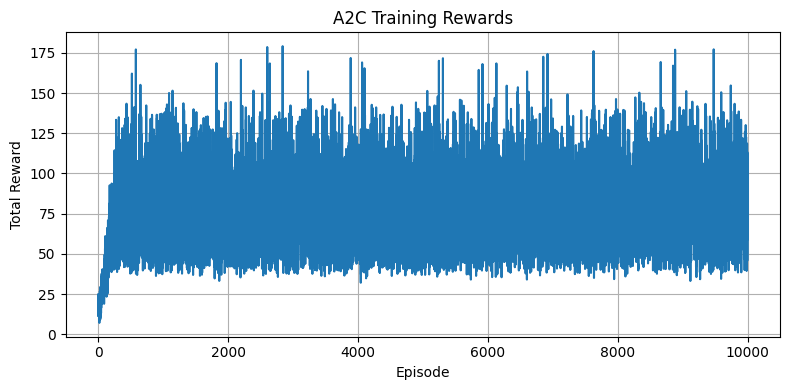

Evaluation over 10 episodes: 62.63 ± 22.50


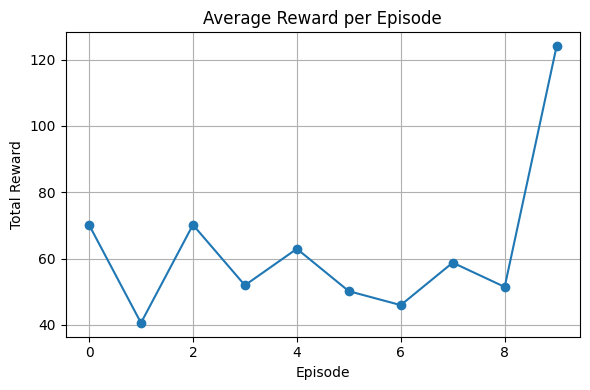

In [15]:
if __name__ == '__main__':
    # Hyperparameters
    num_episodes = 10000
    gamma = 0.99
    learning_rate = 1e-3

    #Creating the environment and model
    environment = CropIrrigationOptimization()
    state_dim = environment.observation_space.shape[0]
    action_dim = environment.action_space.n
    model = ActorCriticModel(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model, training_rewards = train_actor_critic(environment, model, optimizer, num_episodes, gamma)
    torch.save(model.state_dict(), 'a2c_self_10000.pth')
    evaluation_rewards = evaluate_actor_critic(environment, model, num_episodes=10)

    #Plotting the evaluation rewards
    plt.figure(figsize=(6, 4))
    plt.plot(evaluation_rewards, marker='o')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Average Reward per Episode')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('actor_critic_evaluation_rewards.png')
    plt.show()

In [16]:
if __name__ == '__main__':
    environment = CropIrrigationOptimization()
    
    state_dim = environment.observation_space.shape[0]
    action_dim = environment.action_space.n
    model = ActorCriticModel(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.load_state_dict(torch.load('a2c_self_10000.pth', map_location=torch.device('cpu')))
    model.eval()
    renderer = IrrigationRenderer(environment, crop_image_paths={'seedling':'seedling.png', 'vegetative':'vegetative.png', 'mature':'mature.png', 'stressed':'stressed.png'})
    state, _ = environment.reset()
    done = False
    episode_reward = 0.0

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action_probs, _ = model(state_tensor)
        action = int(torch.argmax(action_probs, dim=-1).item())
        next_state, reward, terminated, truncated, _ = environment.step(action)
        done = terminated or truncated
        episode_reward += reward
        state = next_state
        renderer.render(mode='human')
        pygame.time.delay(100)
    print(f"Rendered Episode - Total Reward: {episode_reward:.2f}")
    renderer.close()
    environment.close()

Rendered Episode - Total Reward: 77.05


Stable-Baseline Implementations

DQN Implementation

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | 15       |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 23893    |
|    time_elapsed     | 0        |
|    total_timesteps  | 480      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | 14.5     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 21895    |
|    time_elapsed     | 0        |
|    total_timesteps  | 960      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 120      |
|    ep_rew_mean      | 14.9     |
|    exploration_rate | 0.986    |
| t

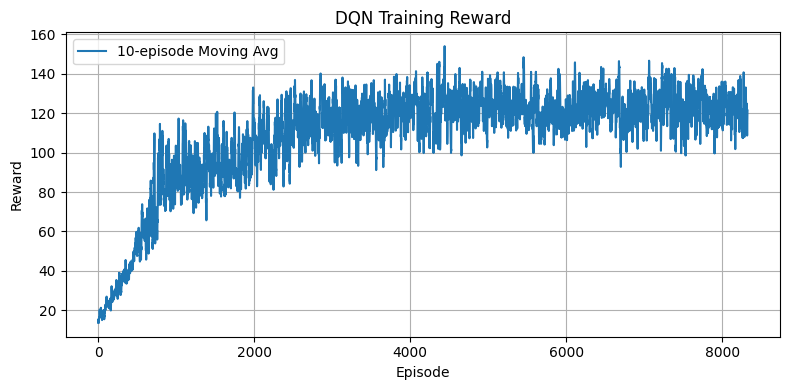

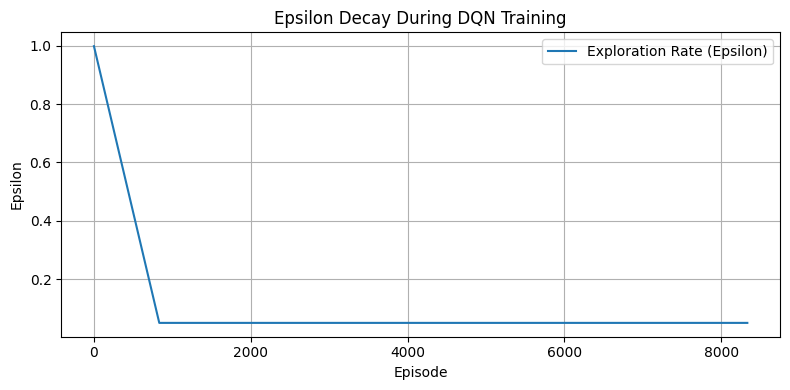

In [ ]:
class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.epsilon_history = []

    def _on_step(self) -> bool:
        infos = self.locals.get('infos', [])
        for info in infos:
            episode_info = info.get('episode')
            if episode_info:
                self.episode_rewards.append(episode_info['r'])
                epsilon = getattr(self.model, 'exploration_rate', None)
                if epsilon is not None:
                    self.epsilon_history.append(epsilon)
        return True

if __name__ == '__main__':
    LOG_DIR = './dqn_sb3_1000000'
    os.makedirs(LOG_DIR, exist_ok=True)
    TOTAL_TIMESTEPS = 1000000
    LEARNING_RATE = 1e-4
    environment = CropIrrigationOptimization()
    check_env(environment)
    environment = Monitor(environment, LOG_DIR)
    model = DQN(policy='MlpPolicy',env=environment,learning_rate=LEARNING_RATE,buffer_size=50_000,learning_starts=1_000,batch_size=64,target_update_interval=500,train_freq=4,verbose=1)
    callback = TrainingLoggerCallback()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback)
    model.save(os.path.join(LOG_DIR, 'dqn_sb3_1000000'))

    #plotting Reward Curve
    rewards = np.array(callback.episode_rewards)
    plt.figure(figsize=(8, 4))
    if len(rewards) >= 10:
        moving_avg = np.convolve(rewards, np.ones(10) / 10, mode='valid')
        plt.plot(moving_avg, label='10-episode Moving Avg')
    else:
        plt.plot(rewards, label='Episode Reward')
    plt.title('DQN Training Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LOG_DIR, 'training_rewards.png'))
    plt.show()

    #plotting Epsilon Decay
    epsilons = callback.epsilon_history
    plt.figure(figsize=(8, 4))
    plt.plot(epsilons, label='Exploration Rate (Epsilon)')
    plt.title('Epsilon Decay During DQN Training')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LOG_DIR, 'epsilon_decay.png'))
    plt.show()


Episode 1 Reward: 119.82
Episode 2 Reward: 161.81
Episode 3 Reward: 149.76
Episode 4 Reward: 156.66
Episode 5 Reward: 159.22
Episode 6 Reward: 134.04
Episode 7 Reward: 121.20
Episode 8 Reward: 128.76
Episode 9 Reward: 143.24
Episode 10 Reward: 70.31


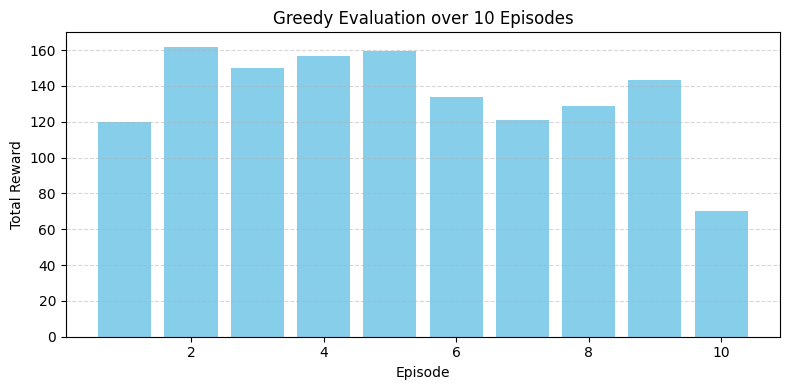


Average Reward over 10 Episodes: 134.48


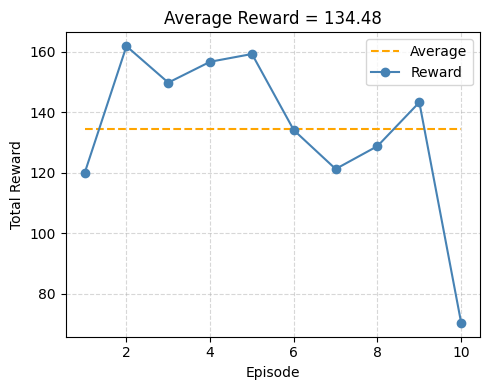

In [18]:
def evaluate_greedy(model_path: str, n_episodes: int = 10):
    model = DQN.load(model_path)
    env = CropIrrigationOptimization()
    episode_rewards = []
    for episode in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1} Reward: {total_reward:.2f}")
    env.close()

    #Plotting reward per-episode
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, n_episodes + 1), episode_rewards, color='skyblue')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Greedy Evaluation over {n_episodes} Episodes")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("dqn_sb3_1000000/eval_rewards_per_episode.png")
    plt.show()

    #Computing and plotting average reward
    avg_reward = sum(episode_rewards) / n_episodes
    print(f"\nAverage Reward over {n_episodes} Episodes: {avg_reward:.2f}")
    plt.figure(figsize=(5, 4))
    plt.hlines(avg_reward, 1, n_episodes, colors='orange', linestyles='--', label='Average')
    plt.plot(range(1, n_episodes + 1), episode_rewards, color='steelblue', marker='o', label='Reward')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Average Reward = {avg_reward:.2f}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("dqn_sb3_1000000/eval_average_reward.png")
    plt.show()

if __name__ == "__main__":
    MODEL_DIR = "dqn_sb3_1000000"
    MODEL_FILENAME = "dqn_sb3_1000000.zip"
    model_path = os.path.join(MODEL_DIR, MODEL_FILENAME)
    evaluate_greedy(model_path, n_episodes=10)


In [19]:
def run_one_episode(model_path: str):
    if not os.path.isfile(model_path):
        print(f"Model not found at {model_path}", file=sys.stderr)
        sys.exit(1)
    model = DQN.load(model_path)
    env = CropIrrigationOptimization()
    renderer = IrrigationRenderer(env, crop_image_paths={'seedling':'seedling.png', 'vegetative': 'vegetative.png', 'mature':'mature.png', 'stressed':'stressed.png'})
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        renderer.render(mode='human')
        pygame.time.delay(100)
    print(f"Episode completed — Total Reward: {total_reward:.2f}")
    renderer.close()
    env.close()

if __name__ == "__main__":
    MODEL_DIR = "dqn_sb3_1000000"
    MODEL_FILENAME = "dqn_sb3_1000000.zip"
    model_path = os.path.join(MODEL_DIR, MODEL_FILENAME)
    run_one_episode(model_path)


Episode completed — Total Reward: 191.11


PPO Implementation

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | 14.6     |
| time/              |          |
|    fps             | 4042     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | 18          |
| time/                   |             |
|    fps                  | 3257        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016174316 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_varia

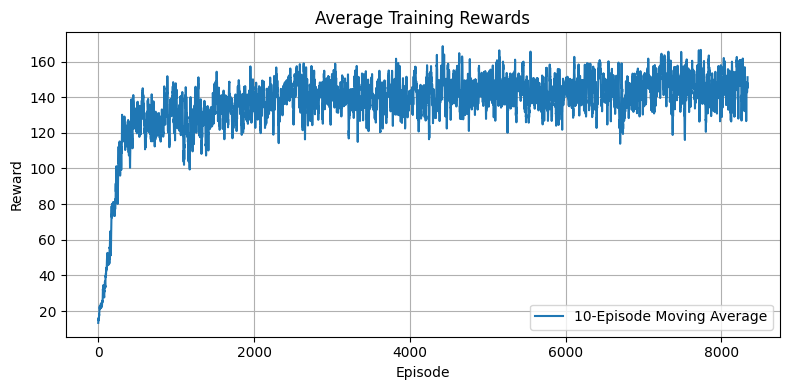

Evaluation total reward: 113.93


In [20]:
class TrainLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.ep_rewards = []

    def _on_step(self) -> bool:
        infos = self.locals.get('infos', [])
        for info in infos:
            ep_info = info.get('episode')
            if ep_info:
                self.ep_rewards.append(ep_info['r'])
        return True

def plot_rewards(rewards, save_path):
    plt.figure(figsize=(8, 4))
    if len(rewards) >= 10:
        ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
        plt.plot(ma, label='10-Episode Moving Average')
    else:
        plt.plot(rewards, label='Episode Reward')
    plt.title('Average Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def evaluate_model(env, model):
    obs, _ = env.reset()
    done = False
    total_reward = 0.0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
    return total_reward

if __name__ == '__main__':
    LOG_DIR = './ppo_sb3_1000000'
    os.makedirs(LOG_DIR, exist_ok=True)
    env = CropIrrigationOptimization()
    check_env(env)
    env = Monitor(env, LOG_DIR)
    model = PPO(policy='MlpPolicy',env=env,learning_rate=1e-4,n_steps=2048,batch_size=64,n_epochs=10,gamma=0.99,gae_lambda=0.95,ent_coef=0.0,clip_range=0.2,verbose=1)
    callback = TrainLoggerCallback()
    TIMESTEPS = 1000000
    model.learn(total_timesteps=TIMESTEPS, callback=callback)
    model_path = os.path.join(LOG_DIR, 'ppo_sb3_1000000')
    model.save(model_path)
    print(f"Model saved to {model_path}.zip")
    rewards = np.array(callback.ep_rewards)
    plot_rewards(rewards, os.path.join(LOG_DIR, 'ppo_sb3_1000000_rewards.png'))
    eval_reward = evaluate_model(env, model)
    print(f"Evaluation total reward: {eval_reward:.2f}")
    env.close()


Episode 1 Reward: 151.72
Episode 2 Reward: 152.97
Episode 3 Reward: 163.69
Episode 4 Reward: 135.38
Episode 5 Reward: 153.89
Episode 6 Reward: 151.35
Episode 7 Reward: 100.05
Episode 8 Reward: 149.04
Episode 9 Reward: 188.62
Episode 10 Reward: 143.84


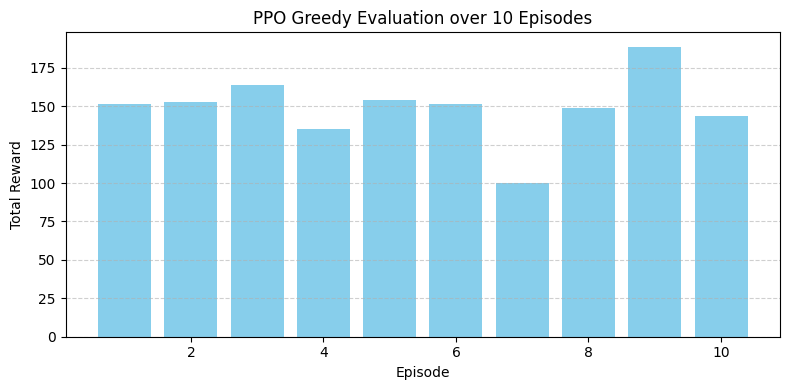


Average Reward over 10 episodes: 149.06


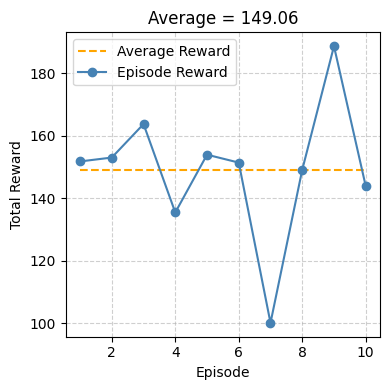

In [21]:
def evaluate_greedy(model_path: str, n_episodes: int = 10):
    model = PPO.load(model_path)
    env = CropIrrigationOptimization()
    episode_rewards = []
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
        episode_rewards.append(total_reward)
        print(f"Episode {ep + 1} Reward: {total_reward:.2f}")
    env.close()

    plt.figure(figsize=(8, 4))
    plt.bar(range(1, n_episodes + 1), episode_rewards, color='skyblue')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"PPO Greedy Evaluation over {n_episodes} Episodes")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("ppo_sb3_1000000_rewards_per_episode.png")
    plt.show()
    
    avg_reward = sum(episode_rewards) / n_episodes
    print(f"\nAverage Reward over {n_episodes} episodes: {avg_reward:.2f}")
    plt.figure(figsize=(4, 4))
    plt.hlines(avg_reward, 1, n_episodes, colors='orange', linestyles='--', label='Average Reward')
    plt.plot(range(1, n_episodes + 1), episode_rewards, color='steelblue', marker='o', label='Episode Reward')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Average = {avg_reward:.2f}")
    plt.legend()
    plt.grid(linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("ppo_sb3_1000000_average_reward.png")
    plt.show()

if __name__ == "__main__":
    MODEL_PATH = os.path.join("ppo_sb3_1000000", "ppo_sb3_1000000.zip")
    evaluate_greedy(MODEL_PATH, n_episodes=10)

In [22]:
def run_one_episode(model_path: str):
    model = PPO.load(model_path)
    env = CropIrrigationOptimization()
    renderer = IrrigationRenderer(env, crop_image_paths={'seedling':'seedling.png', 'vegetative':'vegetative.png', 'mature':'mature.png', 'stressed':'stressed.png'})
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        renderer.render(mode='human')
        pygame.time.delay(100)
    print(f"Episode completed. Total Reward: {total_reward:.2f}")
    renderer.close()
    env.close()
if __name__ == "__main__":
    MODEL_PATH = os.path.join("ppo_sb3_1000000", "ppo_sb3_1000000.zip")
    if not os.path.isfile(MODEL_PATH):
        print(f"Model not found at {MODEL_PATH}", file=sys.stderr)
        sys.exit(1)
    run_one_episode(MODEL_PATH)

Episode completed. Total Reward: 158.10


Implementing A2C

Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 120      |
|    ep_rew_mean        | 30.8     |
| time/                 |          |
|    fps                | 6612     |
|    iterations         | 100      |
|    time_elapsed       | 75       |
|    total_timesteps    | 500000   |
| train/                |          |
|    entropy_loss       | -2.24    |
|    explained_variance | -0.176   |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | 4.9      |
|    value_loss         | 11.5     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 120      |
|    ep_rew_mean        | 45.8     |
| time/                 |          |
|    fps                | 6686     |
|    iterations         | 200      |
|    time_elapsed       | 149      |
|    total_timesteps   

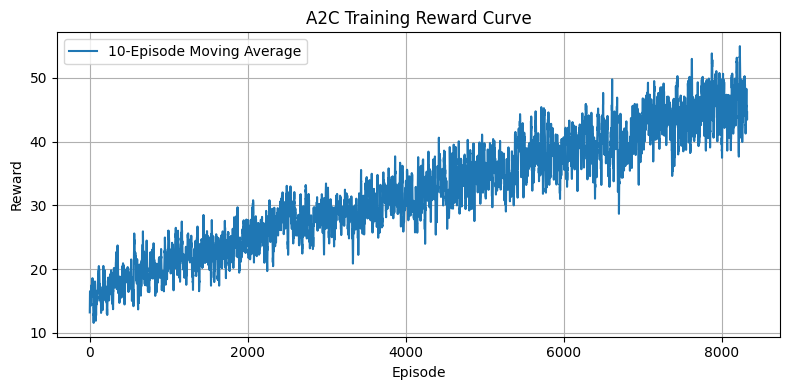

Evaluation total reward: 157.12


In [26]:
class TrainLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.ep_rewards = []
    def _on_step(self) -> bool:
        infos = self.locals.get('infos', [])
        for info in infos:
            ep_info = info.get('episode')
            if ep_info:
                self.ep_rewards.append(ep_info['r'])
        return True

def plot_rewards(rewards, log_dir):
    plt.figure(figsize=(8, 4))
    rewards = np.array(rewards)
    if len(rewards) >= 10:
        moving_avg = np.convolve(rewards, np.ones(10) / 10, mode='valid')
        plt.plot(moving_avg, label='10-Episode Moving Average')
    else:
        plt.plot(rewards, label='Episode Rewards')
    plt.title('A2C Training Reward Curve')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(log_dir, 'a2c_logs_1000000_rewards.png'))
    plt.show()

def evaluate_model(model, env):
    obs, _ = env.reset()
    done = False
    total_reward = 0.0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
    print(f"Evaluation total reward: {total_reward:.2f}")
    return total_reward

if __name__ == '__main__':
    LOG_DIR = './a2c_sb3_1000000'
    os.makedirs(LOG_DIR, exist_ok=True)
    env = CropIrrigationOptimization()
    check_env(env)
    env = Monitor(env, LOG_DIR)
    model = A2C(policy='MlpPolicy',env=env,learning_rate=1e-4,n_steps=5000,gamma=0.99,gae_lambda=0.95,ent_coef=0.01,verbose=1)
    callback = TrainLoggerCallback()
    TIMESTEPS = 1000000
    model.learn(total_timesteps=TIMESTEPS, callback=callback)
    model_path = os.path.join(LOG_DIR, 'a2c_sb3_1000000')
    model.save(model_path)
    print(f"The Model saved to {model_path}.zip")
    plot_rewards(callback.ep_rewards, LOG_DIR)
    evaluate_model(model, env)
    env.close()

Episode 1 Reward: 90.00
Episode 2 Reward: 152.03
Episode 3 Reward: 165.05
Episode 4 Reward: 69.98
Episode 5 Reward: 149.73
Episode 6 Reward: 159.90
Episode 7 Reward: 120.57
Episode 8 Reward: 88.21
Episode 9 Reward: 108.89
Episode 10 Reward: 86.77


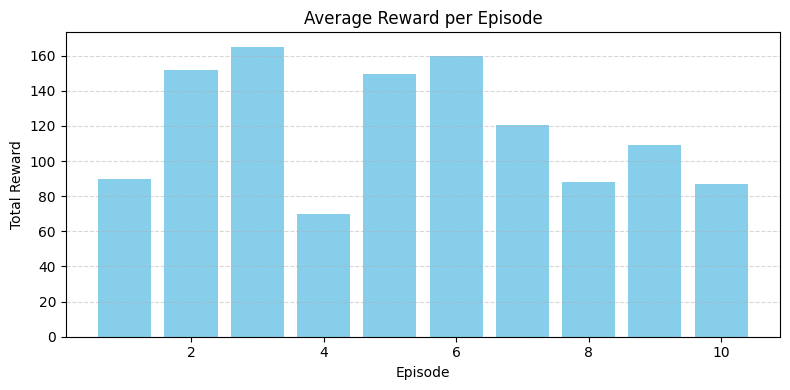


Average Reward over 10 episodes: 119.11


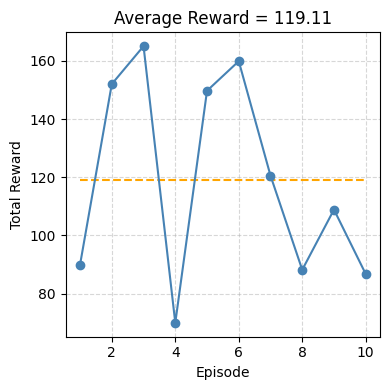

In [27]:
def evaluate_greedy(model_path: str, n_episodes: int = 10, log_dir: str = "a2c_sb3_1000000"):
    model = A2C.load(model_path)
    env = CropIrrigationOptimization()
    episode_rewards = []
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
        episode_rewards.append(total_reward)
        print(f"Episode {ep + 1} Reward: {total_reward:.2f}")
    env.close()

    os.makedirs(log_dir, exist_ok=True)
    per_episode_path = os.path.join(log_dir, "a2c_rewards_per_episode.png")
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, n_episodes + 1), episode_rewards, color='skyblue')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Average Reward per Episode")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(per_episode_path)
    plt.show()

    avg_reward = sum(episode_rewards) / n_episodes
    print(f"\nAverage Reward over {n_episodes} episodes: {avg_reward:.2f}")
    avg_plot_path = os.path.join(log_dir, "a2c_average_reward.png")
    plt.figure(figsize=(4, 4))
    plt.hlines(avg_reward, 1, n_episodes, colors='orange', linestyles='--')
    plt.plot(range(1, n_episodes + 1), episode_rewards, color='steelblue', marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Average Reward = {avg_reward:.2f}")
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(avg_plot_path)
    plt.show()

if __name__ == "__main__":
    MODEL_PATH = os.path.join("a2c_sb3_1000000", "a2c_sb3_1000000.zip")
    evaluate_greedy(MODEL_PATH, n_episodes=10)

In [28]:
def run_one_episode(model_path: str, delay_ms: int = 100):
    model = A2C.load(model_path)
    env = CropIrrigationOptimization()
    renderer = IrrigationRenderer(env, crop_image_paths={'seedling': 'seedling.png', 'vegetative': 'vegetative.png', 'mature':'mature.png', 'stressed':'stressed.png'})
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        renderer.render(mode='human')
        pygame.time.delay(delay_ms)
    print(f"Episode finished with Total reward: {total_reward:.2f}")
    renderer.close()
    env.close()

if __name__ == "__main__":
    MODEL_PATH = os.path.join("a2c_sb3_1000000", "a2c_sb3_1000000.zip")
    if not os.path.isfile(MODEL_PATH):
        print(f"Model not found at {MODEL_PATH}", file=sys.stderr)
        sys.exit(1)
    run_one_episode(MODEL_PATH)

Episode finished with Total reward: 155.44


| Team Member | Project Part | Contribution (%) |
|-------------|--------------|------------------|
|      Mohan        |  All              |     33%             |
|          Udit   |      All        |       33%           |
|         Pavan    |         All     |        33%          |